# Creating a Chatbot with a Memory Network
Adapted from https://towardsdatascience.com/deep-learning-for-nlp-creating-a-chatbot-with-keras-da5ca051e051

In [1]:
#Library Imports
import pickle
import numpy as np
np.random.seed(42)
import tensorflow as tf
print(tf.__version__)

2.0.0


In [2]:
#retrieve training data
with open('train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
#retrieve test data
with open('test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [4]:
#Number of training instances
len(train_data)

10000

In [5]:
#Number of test instances
len(test_data)

1000

In [6]:
#Example of one of the instances
train_data[10]

(['Sandra',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.',
  'Sandra',
  'moved',
  'to',
  'the',
  'office',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'office', '?'],
 'yes')

In [7]:
' '.join(train_data[10][0])

'Sandra went back to the hallway . Sandra moved to the office .'

In [8]:
' '.join(train_data[10][1])

'Is Sandra in the office ?'

In [9]:
train_data[10][2]

'yes'

In [10]:
#First we need to create a vocabulary with our data
#For this we will use the training data only to - On the video it uses both
#train and test 
#Might have to use training and test later, as the dataset has very
#few words

In [11]:
#First we will build a set of all the words in the dataset:
vocab = set()
for story, question, answer in train_data:
    vocab = vocab.union(set(story)) #Set returns unique words in the sentence
                                    #Union returns the unique common elements from a two sets
    vocab = vocab.union(set(question))

In [12]:
vocab.add('no')
vocab.add('yes')

In [13]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [14]:
#Calculate len and add 1 for Keras placeholder - Placeholders are used to feed in the data to the network. 
#They need a data type, and have optional shape arguements.
#They will be empty at first, and then the data will get fed into the placeholder
vocab_len = len(vocab) + 1

In [15]:
vocab_len

38

In [16]:
#Now we are going to calculate the longest story and the longest question
#We need this for the Keras pad sequences. 
#Keras training layers expect all of the input to have the same length, so 
#we need to pad 
all_data = test_data + train_data

In [17]:
all_story_lens = [len(data[0]) for data in all_data]

In [18]:
max_story_len = (max(all_story_lens))

In [19]:
max_question_len = max([len(data[1]) for data in all_data])

## Vectorizing the data

First, we will go through a manual process of how to vectorize the data, and then we will create a function that does this automatically for us. 

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [21]:
#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab)

In [22]:
#Dictionary that maps every word in our vocab to an index
# It has been automatically lowercased
#This tokenizer can give different indexes for different words depending on when we run it
tokenizer.word_index

{'is': 1,
 'hallway': 2,
 'no': 3,
 'grabbed': 4,
 'football': 5,
 'picked': 6,
 'yes': 7,
 'back': 8,
 'bedroom': 9,
 'there': 10,
 'kitchen': 11,
 'got': 12,
 '?': 13,
 'discarded': 14,
 'garden': 15,
 'to': 16,
 'left': 17,
 'dropped': 18,
 'sandra': 19,
 'the': 20,
 'john': 21,
 'bathroom': 22,
 'journeyed': 23,
 'went': 24,
 'daniel': 25,
 'up': 26,
 'apple': 27,
 'office': 28,
 'put': 29,
 'mary': 30,
 '.': 31,
 'took': 32,
 'travelled': 33,
 'down': 34,
 'milk': 35,
 'moved': 36,
 'in': 37}

In [23]:
#Tokenize the stories, questions and answers:
train_story_text = []
train_question_text = []
train_answers = []

In [24]:
#Separating each of the elements
for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question) 
    train_answers.append(answer)
    

In [25]:
#Coverting the text into the indexes 
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [26]:
#Create a function for vectorizing the stories, questions and answers:
def vectorize_stories(data,word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len):
    #vectorized stories:
    X = []
    #vectorized questions:
    Xq = []
    #vectorized answers:
    Y = []
    
    for story, question, answer in data:
        #Getting indexes for each word in the story
        x = [word_index[word.lower()] for word in story]
        #Getting indexes for each word in the story
        xq = [word_index[word.lower()] for word in question]
        #For the answers
        y = np.zeros(len(word_index) + 1) #Index 0 Reserved when padding the sequences
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    #Now we have to pad these sequences:
    return(pad_sequences(X,maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))
        

In [27]:
inputs_train, questions_train, answers_train = vectorize_stories(train_data)

In [28]:
inputs_test, questions_test, answers_test = vectorize_stories(test_data)

In [29]:
inputs_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 30, 36, 16, 20, 22, 31, 19, 23, 16,
       20,  9, 31], dtype=int32)

In [30]:
train_story_text[0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [31]:
train_story_seq[0]

[30, 36, 16, 20, 22, 31, 19, 23, 16, 20, 9, 31]

## Building the Network

In [32]:
#Imports
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [33]:
# We need to create the placeholders 
#The Input function is used to create a keras tensor
#PLACEHOLDER shape = (max_story_len,batch_size)
#These are our placeholder for the inputs, ready to recieve batches of the stories and the questions
input_sequence = Input((max_story_len,)) #As we dont know batch size yet
question = Input((max_question_len,))

In [34]:
#Create input encoder M:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim = 64)) #From paper
input_encoder_m.add(Dropout(0.3))

#Outputs: (Samples, story_maxlen,embedding_dim) -- Gives a list of the lenght of the samples where each item has the
#lenght of the max story lenght and every word is embedded in the embbeding dimension

In [35]:
#Create input encoder C:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim = max_question_len)) #From paper
input_encoder_c.add(Dropout(0.3))

#Outputs: (samples, story_maxlen, max_question_len)

In [36]:
#Create question encoder:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim = 64,input_length=max_question_len)) #From paper
question_encoder.add(Dropout(0.3))

#Outputs: (samples, question_maxlen, embedding_dim)

In [37]:
#Now lets encode the sequences, passing the placeholders into our encoders:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [38]:
#Use dot product to compute similarity between input encoded m and question 
#Like in the paper:
match = dot([input_encoded_m,question_encoded], axes = (2,2))
match = Activation('softmax')(match)

In [39]:
#For the response we want to add this match with the ouput of input_encoded_c
response = add([match,input_encoded_c])
response = Permute((2,1))(response) #Permute Layer: permutes dimensions of input

In [40]:
#Once we have the response we can concatenate it with the question encoded:
answer = concatenate([response, question_encoded])

In [41]:
answer

<tf.Tensor 'concatenate/Identity:0' shape=(None, 6, 220) dtype=float32>

In [42]:
# Reduce the answer tensor with a RNN (LSTM)
answer = LSTM(32)(answer)

In [43]:
#Regularization with dropout:
answer = Dropout(0.5)(answer)
#Output layer:
answer = Dense(vocab_len)(answer) #Output shape: (Samples, Vocab_size) #Yes or no and all 0s

In [44]:
#Now we need to output a probability distribution for the vocab, using softmax:
answer = Activation('softmax')(answer)

In [45]:
#Now we build the final model:
model = Model([input_sequence,question], answer)

In [46]:
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Categorical instead of binary cross entropy as because of the way we are training
#we could actually see any of the words from the vocab as output
#however, we should only see yes or no

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

In [49]:
# make sure graphviz is installed in terminal
#sudo apt-get install graphviz
!pip install pydot


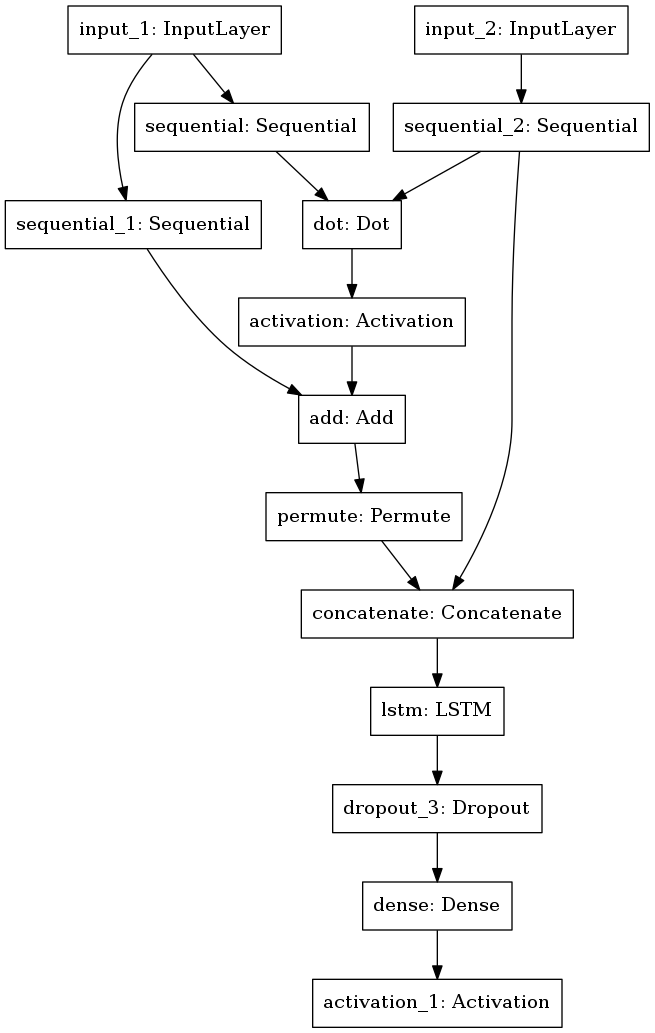

In [51]:
tf.keras.utils.plot_model(model)

## Training and testing the model

In [ ]:
history = model.fit([inputs_train,questions_train],answers_train, batch_size = 32, epochs = 100, validation_data = ([inputs_test,questions_test],answers_test))

In [ ]:
filename = 'Z_chatbot_100_epochs.h5'
model.save(filename)

In [ ]:
#Lets plot the increase of accuracy as we increase the number of training epochs
#We can see that without any training the acc is about 50%, random guessing
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12,12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#To load a model that we have already trained and saved:
model.load_weights('Z_chatbot_100_epochs.h5')

In [ ]:
#Lets check out the predictions on the test set:
#These are just probabilities for every single word on the vocab
pred_results = model.predict(([inputs_test,questions_test]))

In [ ]:
#First test data point
test_data[0]

In [ ]:
#These are the probabilities for the vocab words using the 1st sentence
pred_results[0]

In [ ]:
val_max = np.argmax(pred_results[0])

In [ ]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
print(k)

In [ ]:
#See probability:
pred_results[0][val_max]

In [ ]:
#Now, we can make our own questions using the vocabulary we have
vocab

In [ ]:
my_story = 'Sandra picked the apple . Mary went up . '

In [ ]:
my_story.split()

In [ ]:
my_question = 'Mary got the apple ?'

In [ ]:
my_question.split()

In [ ]:
#Put the data in the same format as before
my_data = [(my_story.split(), my_question.split(),'yes')]

In [ ]:
#Vectorize this data
my_story, my_ques, my_ans = vectorize_stories(my_data)

In [ ]:
#Make the prediction
pred_results = model.predict(([my_story,my_ques]))

In [ ]:
val_max = np.argmax(pred_results[0])

In [ ]:
#Correct prediction!
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
print(k)

In [ ]:
#Confidence
pred_results[0][val_max]

In [ ]:
val_max

In [ ]:
val

In [ ]:
print(k, key)